# 1.0 An end-to-end classification problem (Training)



## 1.1 Dataset description

The notebooks focus on a borrower's **credit modeling problem**. The database was downloaded through a dataquest project and is available at link below. The data is from **Lending Club** and contains data from loans made in the period **2007 to 2011**. Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. The **target variable**, or what we are wanting to predict, is whether or not, given a person's history, they will repay the loan.

You can download the data from the [Kaggle](https://www.kaggle.com/datasets/samaxtech/lending-club-20072011-data).

Let's take the following steps:

1. ETL (done)
2. Data Checks (done)
3. Data Segregation (done)
4. Training

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1fKGuR5U5ECf7On6Zo1UWzAIWZrMmZnGc"></center>

## 1.2 Install, load libraries

In [ ]:
# !pip install wandb

In [2]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

WANDB_API_KEY=os.environ.get('WANDB_API_KEY')

In [4]:
# Login to Weights & Biases
!wandb login --relogin $WANDB_API_KEY

wandb: Appending key for api.wandb.ai to your netrc file: /Users/phamdinhkhanh/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


## 1.3 Holdout Configuration

In [5]:
# global variables

# ratio used to split train and validation data
val_size = 0.30

# seed used to reproduce purposes
seed = 41

# reference (column) to stratify the data
stratify = "loan_status"

# name of the input artifact
artifact_input_name = "risk_credit/train.csv:latest"

# type of the artifact
artifact_type = "Train"

In [6]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="risk_credit",job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")
# split-out train/validation and test dataset
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aikhanhblog (aikhanhblog-datascienceworld-kan). Use `wandb login --relogin` to force relogin


23-03-2025 16:02:58 Downloading and reading train artifact
23-03-2025 16:03:00 Spliting data into train/val


In [7]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

23-03-2025 16:03:00 x train: (18460, 17)
23-03-2025 16:03:00 y train: (18460,)
23-03-2025 16:03:00 x val: (7912, 17)
23-03-2025 16:03:00 y val: (7912,)


## 1.4 Data preparation

### 1.4.1 Outlier Removal

In [8]:
logger.info("Outlier Removal")
# temporary variable
x = x_train.select_dtypes("float64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

23-03-2025 16:03:01 Outlier Removal


In [9]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

23-03-2025 16:03:03 x_train shape [original]: (18460, 17)
23-03-2025 16:03:03 x_train shape [outlier removal]: (18431, 17)


In [10]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

### 1.4.2 Encoding Target Variable

In [11]:
y_train.head(10)

5525     Fully Paid
19011    Fully Paid
20964    Fully Paid
20533    Fully Paid
8244     Fully Paid
8138     Fully Paid
12371    Fully Paid
3891     Fully Paid
21678    Fully Paid
5197     Fully Paid
Name: loan_status, dtype: object

In [12]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train
y_train = le.fit_transform(y_train)

# transform y_test (avoiding data leakage)
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

23-03-2025 16:03:08 Encoding Target Variable
23-03-2025 16:03:08 Classes [0, 1]: ['Charged Off' 'Fully Paid']


In [13]:
y_train

array([1, 1, 1, ..., 1, 1, 0])

In [14]:
y_val

array([1, 0, 1, ..., 0, 1, 1])

### 1.4.3 Using a full-pipeline

```
A reproducible pipeline is all you need
```

#### 1.4.3.1 Feature Extractor

In [15]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

In [16]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,term,emp_length,home_ownership,verification_status,purpose
5525,60 months,< 1 year,RENT,Source Verified,wedding
19011,36 months,10+ years,MORTGAGE,Verified,other
20964,36 months,5 years,RENT,Source Verified,debt_consolidation
20533,36 months,3 years,MORTGAGE,Not Verified,credit_card
8244,36 months,3 years,RENT,Verified,other


In [17]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("float64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
5525,14400.0,17.93,243.42,120000.0,21.60,0.0,0.0,15.0,0.0,25420.0,73.3,25.0
19011,16000.0,11.71,529.22,88000.0,19.95,0.0,0.0,8.0,0.0,12075.0,41.2,56.0
20964,10000.0,7.88,312.82,64800.0,13.98,0.0,2.0,7.0,0.0,364.0,1.6,26.0
20533,5700.0,6.91,175.77,45000.0,7.57,0.0,1.0,4.0,0.0,5057.0,56.2,23.0
8244,2000.0,10.99,65.47,50400.0,24.71,0.0,0.0,22.0,0.0,27541.0,88.8,30.0


#### 1.4.3.2 Handling Categorical Features

In [18]:
# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # customize feature?
        # How can I identify what needs to be modified? EDA!!!!
        if self.new_features:

            #adjust emp_lenght feature
            mapping_dict = {
                "emp_length": {
                    "10+ years": 10,
                    "9 years": 9,
                    "8 years": 8,
                    "7 years": 7,
                    "6 years": 6,
                    "5 years": 5,
                    "4 years": 4,
                    "3 years": 3,
                    "2 years": 2,
                    "1 year": 1,
                    "< 1 year": 0,
                    "n/a": 0
                }
            }
            df = df.replace(mapping_dict)

        # update column names
        self.colnames = df.columns
            
        return df


In [19]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,term,emp_length,home_ownership,verification_status,purpose
5525,60 months,< 1 year,RENT,Source Verified,wedding
19011,36 months,10+ years,MORTGAGE,Verified,other
20964,36 months,5 years,RENT,Source Verified,debt_consolidation
20533,36 months,3 years,MORTGAGE,Not Verified,credit_card
8244,36 months,3 years,RENT,Verified,other


In [20]:
# for validation purposes
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

,term,emp_length,home_ownership,verification_status,purpose
5525,60 months,0,RENT,Source Verified,wedding
19011,36 months,10,MORTGAGE,Verified,other
20964,36 months,5,RENT,Source Verified,debt_consolidation
20533,36 months,3,MORTGAGE,Not Verified,credit_card
8244,36 months,3,RENT,Verified,other


#### 1.4.3.3 Handling Numerical Features

In [21]:
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [22]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("float64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
5525,14400.0,17.93,243.42,120000.0,21.60,0.0,0.0,15.0,0.0,25420.0,73.3,25.0
19011,16000.0,11.71,529.22,88000.0,19.95,0.0,0.0,8.0,0.0,12075.0,41.2,56.0
20964,10000.0,7.88,312.82,64800.0,13.98,0.0,2.0,7.0,0.0,364.0,1.6,26.0
20533,5700.0,6.91,175.77,45000.0,7.57,0.0,1.0,4.0,0.0,5057.0,56.2,23.0
8244,2000.0,10.99,65.47,50400.0,24.71,0.0,0.0,22.0,0.0,27541.0,88.8,30.0


In [23]:
# for validation purposes
nt = NumericalTransformer(model=1)
df_num = nt.fit_transform(df)
df_num

array([[ 0.43105921,  1.61158526, -0.39726645, ...,  0.76559949,
         0.86201652,  0.26250589],
       [ 0.64767724, -0.07295841,  0.96521003, ..., -0.0789009 ,
        -0.27370592,  2.99922025],
       [-0.16464039, -1.11022565, -0.06642017, ..., -0.81999824,
        -1.67478408,  0.350787  ],
       ...,
       [ 1.18922233, -0.23545458,  0.52056978, ..., -0.58300656,
        -1.31390032, -1.59139738],
       [-0.69264684, -0.26795382, -0.92557171, ..., -0.08605178,
         1.44933716, -0.62030519],
       [-0.16464039,  0.33599029,  0.05366654, ...,  0.09493519,
         0.97169688, -1.23827295]])

In [24]:
# return columns name
nt.get_feature_names_out()

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc']

#### 1.4.3.4 Data Preparation Pipeline

In [25]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 0

# Categrical features to pass down the categorical pipeline
categorical_features = x_train.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline
numerical_features = x_train.select_dtypes("float64").columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       ('cat_encoder', OneHotEncoder(handle_unknown="ignore",sparse=False, drop="first"))
                                       ]
                                )

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model, 
                                                                              colnames=numerical_features))])

# Combine numerical and categorical pipelines into one full big pipeline horizontally
full_pipeline_preprocessing = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)]
                              )

In [26]:
# for validation purposes
new_data = full_pipeline_preprocessing.fit_transform(x_train)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
df = pd.DataFrame(new_data,columns = cat_names + num_names)
df.head()

,term_60 months,emp_length_1,emp_length_2,emp_length_3,emp_length_4,emp_length_5,emp_length_6,emp_length_7,emp_length_8,emp_length_9,...,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.176550,0.127517,0.721202,0.0,0.000,0.325,0.0,0.170003,0.733734,0.261364
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.398724,0.091723,0.666110,0.0,0.000,0.150,0.0,0.080755,0.412412,0.613636
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.230500,0.065772,0.466778,0.0,0.250,0.125,0.0,0.002434,0.016016,0.272727
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.123960,0.043624,0.252755,0.0,0.125,0.050,0.0,0.033820,0.562563,0.238636
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.038216,0.049664,0.825042,0.0,0.000,0.500,0.0,0.184187,0.888889,0.318182


In [27]:
df.shape

(18431, 42)

In [28]:
x_train.shape

(18431, 17)

In [29]:
y_train.shape

(18431,)

## 1.5 Holdout Training

In this example the inference artifacts are:
- pipe (contains trained model and the preprocesing pipeline)
- le (label encoder object used to encode the target variable)

In [30]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

23-03-2025 16:04:15 Training
23-03-2025 16:04:15 Infering
23-03-2025 16:04:15 Evaluation metrics
23-03-2025 16:04:15 Accuracy: 0.7635237613751263
23-03-2025 16:04:15 Precision: 0.8684882149827353
23-03-2025 16:04:15 Recall: 0.8532448377581121
23-03-2025 16:04:15 F1: 0.860799047689904


In [31]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [32]:
# predict bias
logger.info("Infering Bias")
predict_bias = pipe.predict(x_train)

# Evaluation Metrics
logger.info("Bias Evaluation metrics")
fbeta = fbeta_score(y_train, predict_bias, beta=1, zero_division=1)
precision = precision_score(y_train, predict_bias, zero_division=1)
recall = recall_score(y_train, predict_bias, zero_division=1)
acc = accuracy_score(y_train, predict_bias)

logger.info("Bias Accuracy: {}".format(acc))
logger.info("Bias Precision: {}".format(precision))
logger.info("Bias Recall: {}".format(recall))
logger.info("Bias F1: {}".format(fbeta))

23-03-2025 16:04:20 Infering Bias
23-03-2025 16:04:20 Bias Evaluation metrics
23-03-2025 16:04:20 Bias Accuracy: 1.0
23-03-2025 16:04:20 Bias Precision: 1.0
23-03-2025 16:04:20 Bias Recall: 1.0
23-03-2025 16:04:20 Bias F1: 1.0


In [33]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_val,predict))

              precision    recall  f1-score   support

           0       0.20      0.23      0.21      1132
           1       0.87      0.85      0.86      6780

    accuracy                           0.76      7912
   macro avg       0.54      0.54      0.54      7912
weighted avg       0.77      0.76      0.77      7912



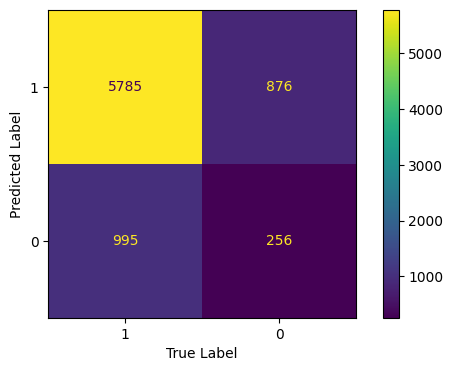

In [34]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_val,labels=[1,0]),
                       display_labels=["1","0"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [35]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

23-03-2025 16:04:24 Uploading figures


In [36]:
# Feature importance
pipe.get_params()["classifier"].feature_importances_

array([0.01013164, 0.00625454, 0.01013111, 0.00870702, 0.00583588,
       0.00984028, 0.00473062, 0.00615503, 0.00330649, 0.00378374,
       0.01128142, 0.        , 0.00066476, 0.00789779, 0.00792012,
       0.01010058, 0.00866394, 0.0039284 , 0.00967946, 0.00123352,
       0.00310678, 0.00102441, 0.00348829, 0.00434918, 0.00310045,
       0.00486192, 0.00166172, 0.00577373, 0.00199261, 0.002185  ,
       0.04477238, 0.10708251, 0.08746899, 0.09825508, 0.09784867,
       0.00981583, 0.02383575, 0.06671602, 0.00970028, 0.11120928,
       0.09804247, 0.08346231])

In [37]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

['term_60 months',
 'emp_length_1',
 'emp_length_2',
 'emp_length_3',
 'emp_length_4',
 'emp_length_5',
 'emp_length_6',
 'emp_length_7',
 'emp_length_8',
 'emp_length_9',
 'emp_length_10',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding']

In [38]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc']

In [39]:
# merge all column names together
all_names = cat_names + num_names
all_names

['term_60 months',
 'emp_length_1',
 'emp_length_2',
 'emp_length_3',
 'emp_length_4',
 'emp_length_5',
 'emp_length_6',
 'emp_length_7',
 'emp_length_8',
 'emp_length_9',
 'emp_length_10',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc']

In [40]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='DT', feature_names=all_names)

wandb: 
wandb: Plotting DT.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [41]:
# Visualize single plot
wandb.sklearn.plot_confusion_matrix(y_val, predict, [0,1])

In [42]:
# Catch up the class proportions between train and validation
wandb.sklearn.plot_class_proportions(y_train, y_val, [0,1])

In [43]:
# Plot the importance of columns
wandb.sklearn.plot_feature_importances(pipe.get_params()["classifier"],all_names)

In [44]:
# Plot a brief summary of the weighted avg results (recall, precision, f1, acc)
wandb.sklearn.plot_summary_metrics(pipe.get_params()["classifier"],
                                    full_pipeline_preprocessing.transform(x_train),
                                    y_train,
                                    full_pipeline_preprocessing.transform(x_val),
                                    y_val)

In [45]:
# ROC curve
predict_proba = pipe.predict_proba(x_val)
wandb.sklearn.plot_roc(y_val, predict_proba, [0,1])

In [46]:
person1 = pd.DataFrame([[5000.0,'36 months', 5, 162.87, "10+ years", "RENT", 24000, "Verified", "car", 27.65,
                0.0, 1.0, 3.0, 0.0, 13648.0, 83.7, 9.0]], columns=x_train.columns)
pred = pipe.predict(person1)
print(pred[0])

1


In [47]:
person2 = pd.DataFrame([[21000.0,'36 months', 12.42, 701.73, "10+ years", "RENT", 105000, "Verified", "debt_consolidation", 13.22,
                0.0, 0.0, 7.0, 0.0, 32135.0, 90.3, 38.0]], columns=x_train.columns)
print(pipe.predict(person2))

[0]


In [48]:
# close the current run before to execute the next section
run.finish()

Acc,0.76352
F1,0.8608
Precision,0.86849
Recall,0.85324


## 1.6 Hyperparameter Tuning

In [ ]:
# To see all parameters of a specific step of the pipeline
# pipe.named_steps['classifier'].get_params() #or
# pipe.named_steps['full_pipeline'].get_params()

In [49]:
# global seed
seed = 41

In [65]:
sweep_config = {
    # try grid or random
    "method": "random",
    "metric": {
        "name": "Accuracy",
        "goal": "maximize"
        },
    "parameters": {
        "criterion": {
            "values": ["gini","entropy"]
            },
        "splitter": {
            "values": ["random","best"]
        },
        "model": {
            "values": [0,1,2]
        },
        "random_state": {
            "values": [seed]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="risk_credit")

Create sweep with ID: 97upzt44
Sweep URL: https://wandb.ai/aikhanhblog-datascienceworld-kan/risk_credit/sweeps/97upzt44


In [66]:
def train():
    with wandb.init() as run:

        # The full pipeline 
        pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                                    ("classifier",DecisionTreeClassifier())
                                    ]
                        )

        # update the parameters of the pipeline that we would like to tuning
        pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": run.config.model})
        pipe.set_params(**{"classifier__criterion": run.config.criterion})
        pipe.set_params(**{"classifier__splitter": run.config.splitter})
        pipe.set_params(**{"classifier__random_state": run.config.random_state})

        # training
        logger.info("Training")
        pipe.fit(x_train, y_train)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        logger.info("Evaluation metrics")
        fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
        precision = precision_score(y_val, predict, zero_division=1)
        recall = recall_score(y_val, predict, zero_division=1)
        acc = accuracy_score(y_val, predict)

        logger.info("Accuracy: {}".format(acc))
        logger.info("Precision: {}".format(precision))
        logger.info("Recall: {}".format(recall))
        logger.info("F1: {}".format(fbeta))

        run.summary["Accuracy"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta

In [67]:
wandb.agent(sweep_id, train, count=8)

wandb: Agent Starting Run: u8wwwtmp with config:
wandb: 	criterion: gini
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: random


23-03-2025 16:13:55 Training
23-03-2025 16:13:55 Infering
23-03-2025 16:13:55 Evaluation metrics
23-03-2025 16:13:55 Accuracy: 0.7601112234580384
23-03-2025 16:13:55 Precision: 0.8687311178247734
23-03-2025 16:13:55 Recall: 0.8482300884955752
23-03-2025 16:13:55 F1: 0.8583582089552239


Accuracy,0.76011
F1,0.85836
Precision,0.86873
Recall,0.84823


wandb: Agent Starting Run: xj9bgxtf with config:
wandb: 	criterion: entropy
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: random


23-03-2025 16:14:06 Training
23-03-2025 16:14:06 Infering
23-03-2025 16:14:06 Evaluation metrics
23-03-2025 16:14:06 Accuracy: 0.7742669362992922
23-03-2025 16:14:06 Precision: 0.8698163507109005
23-03-2025 16:14:06 Recall: 0.8662241887905605
23-03-2025 16:14:06 F1: 0.8680165533550104


Accuracy,0.77427
F1,0.86802
Precision,0.86982
Recall,0.86622


wandb: Agent Starting Run: isj71dbj with config:
wandb: 	criterion: gini
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: random


23-03-2025 16:14:11 Training
23-03-2025 16:14:11 Infering
23-03-2025 16:14:11 Evaluation metrics
23-03-2025 16:14:11 Accuracy: 0.7601112234580384
23-03-2025 16:14:11 Precision: 0.8687311178247734
23-03-2025 16:14:11 Recall: 0.8482300884955752
23-03-2025 16:14:11 F1: 0.8583582089552239


Accuracy,0.76011
F1,0.85836
Precision,0.86873
Recall,0.84823


wandb: Agent Starting Run: w6doqk5w with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: best


23-03-2025 16:14:17 Training
23-03-2025 16:14:17 Infering
23-03-2025 16:14:17 Evaluation metrics
23-03-2025 16:14:17 Accuracy: 0.7665571284125379
23-03-2025 16:14:17 Precision: 0.8675309193860825
23-03-2025 16:14:17 Recall: 0.8587020648967552
23-03-2025 16:14:17 F1: 0.8630939144614928


Accuracy,0.76656
F1,0.86309
Precision,0.86753
Recall,0.8587


wandb: Agent Starting Run: n15yh6v7 with config:
wandb: 	criterion: gini
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


23-03-2025 16:14:22 Training
23-03-2025 16:14:22 Infering
23-03-2025 16:14:22 Evaluation metrics
23-03-2025 16:14:22 Accuracy: 0.7601112234580384
23-03-2025 16:14:22 Precision: 0.8687311178247734
23-03-2025 16:14:22 Recall: 0.8482300884955752
23-03-2025 16:14:22 F1: 0.8583582089552239


Accuracy,0.76011
F1,0.85836
Precision,0.86873
Recall,0.84823


wandb: Agent Starting Run: j6pqyozr with config:
wandb: 	criterion: gini
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


23-03-2025 16:14:27 Training
23-03-2025 16:14:28 Infering
23-03-2025 16:14:28 Evaluation metrics
23-03-2025 16:14:28 Accuracy: 0.7606167846309403
23-03-2025 16:14:28 Precision: 0.8683655006031363
23-03-2025 16:14:28 Recall: 0.8494100294985251
23-03-2025 16:14:28 F1: 0.8587831792424695


Accuracy,0.76062
F1,0.85878
Precision,0.86837
Recall,0.84941


wandb: Agent Starting Run: 4xkebg20 with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: best


23-03-2025 16:14:33 Training
23-03-2025 16:14:33 Infering
23-03-2025 16:14:33 Evaluation metrics
23-03-2025 16:14:33 Accuracy: 0.7665571284125379
23-03-2025 16:14:33 Precision: 0.8675309193860825
23-03-2025 16:14:33 Recall: 0.8587020648967552
23-03-2025 16:14:33 F1: 0.8630939144614928


Accuracy,0.76656
F1,0.86309
Precision,0.86753
Recall,0.8587


wandb: Agent Starting Run: zx6srhd3 with config:
wandb: 	criterion: entropy
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: random


23-03-2025 16:14:38 Training
23-03-2025 16:14:38 Infering
23-03-2025 16:14:38 Evaluation metrics
23-03-2025 16:14:38 Accuracy: 0.7742669362992922
23-03-2025 16:14:38 Precision: 0.8698163507109005
23-03-2025 16:14:38 Recall: 0.8662241887905605
23-03-2025 16:14:38 F1: 0.8680165533550104


Accuracy,0.77427
F1,0.86802
Precision,0.86982
Recall,0.86622


## 1.7 Configure and train the best model

In [68]:
# Note that a new run is yet synced to last sweep run
# Just to check
run = wandb.init()

<font color="red">Important</font> to restart the colab to unlink a new experiment (run) with the last ```sweep``` experiment. 

```
Runtime >> Factory reset runtime
```
> Re-run all cells except for: ```1.5``` and ```1.6```. 

In [69]:
# initiate the wandb project
#run = wandb.init(project="risk_credit",job_type="train")

In [70]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 2})
pipe.set_params(**{"classifier__criterion": 'entropy'})
pipe.set_params(**{"classifier__splitter": 'random'})
pipe.set_params(**{"classifier__random_state": 41})



# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

23-03-2025 16:16:39 Training
23-03-2025 16:16:39 Infering
23-03-2025 16:16:39 Evaluation metrics
23-03-2025 16:16:39 Accuracy: 0.7742669362992922
23-03-2025 16:16:39 Precision: 0.8698163507109005
23-03-2025 16:16:39 Recall: 0.8662241887905605
23-03-2025 16:16:39 F1: 0.8680165533550104


In [71]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

['term_60 months',
 'emp_length_1',
 'emp_length_2',
 'emp_length_3',
 'emp_length_4',
 'emp_length_5',
 'emp_length_6',
 'emp_length_7',
 'emp_length_8',
 'emp_length_9',
 'emp_length_10',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding']

In [72]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc']

In [73]:
# merge all column names together
all_names = cat_names + num_names
all_names

['term_60 months',
 'emp_length_1',
 'emp_length_2',
 'emp_length_3',
 'emp_length_4',
 'emp_length_5',
 'emp_length_6',
 'emp_length_7',
 'emp_length_8',
 'emp_length_9',
 'emp_length_10',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc']

In [74]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

wandb: 
wandb: Plotting BestModel.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
/Users/phamdinhkhanh/Documents/Courses/DataScienceWorld.Kan/MLOps/credit_risk_mlops/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


## 1.8 Export the best model

In [75]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

In [76]:
logger.info("Dumping the artifacts to disk")
# Save the model using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

23-03-2025 16:17:10 Dumping the artifacts to disk


['target_encoder']

In [77]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and a Decision Tree model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

23-03-2025 16:17:11 Logging model artifact


<Artifact model_export>

In [78]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

23-03-2025 16:17:11 Logging target enconder artifact


<Artifact target_encoder>

In [ ]:
run.finish()